In [1]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For GIS related function
import pyproj
from shapely.geometry import LineString, Point

# For loading netcdf
import netCDF4

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

from hkvpy import plotting

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

C:\Anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Loading BokehJS ...

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


In [3]:
execute_notebook('analysis/satellite/get-data.ipynb')

In [4]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]

# The alpha values are the dominant wind direction for the coast stations.
alphas = {
    "delfzijl": 117,
    "harlingen": 108,
    "den helder": 107,
    "ijmuiden": 110,
    "hoek van holland": 117,
    "vlissingen": 118
}

# Wind station at sea is about 50 km from IJmuiden (Locatie wind data is 50 km uit kust vanuit IJmuiden)
rlr_data = get_station_data(
    dataset_name='rlr_annual',
    coastline_code=150,
    names=station_names,
    alphas=alphas,
    include_wind=True
)
rlr_data

Found monthly mean U10 at point: 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


,lat,lon,name,coastline_code,station_code,quality,url,data
id,,,,,,,,
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...


In [5]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u', 'v', 'u2', 'v2', 'u2main', 'u2perp']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'The sea water level data from the following stations shall be analyzed: {", ".join(station_names)}')

The sea water level data from the following stations shall be analyzed: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


In [6]:
def linear_model_with_corrected_wind(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    
    X = np.c_[
        X,
        df['u2main'],
        df['u2perp']
    ]
    names.extend(['Wind U^2 main', 'Wind U^2 perp'])
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HAC', cov_kwds={'maxlags':1})
    return fit, names

In [7]:
tables = {}

# first the model without wind
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
tables['without'] = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')
display(tables['without'])

# and then the model with wind
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
tables['with wind'] = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1948-current)'
)
display(tables['with wind'])

# and then the model with wind
linear_with_corrected_wind_fit, names = linear_model_with_corrected_wind(mean_df)
tables['with corrected wind'] = linear_with_corrected_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with corrected wind (1948-current)'
)
display(tables['with corrected wind'])

# if (linear_fit.aic < linear_with_wind_fit.aic):
#     print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
# else:
#     print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')

# Load surge and convert from meters to mm
# File surge.pkl (~ 100 MB) is saved in a local local folder)
# surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000
surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000

# Calculate average over given stations, per year
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)

# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

mean_df.head()

mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']

linear_fit_corrected, names = linear_model(mean_df_corrected, with_wind=False, with_season=False)
table = linear_fit_corrected.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model corrected for surge (1979-current)'
)
display(table)

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model with corrected wind (1948-current): AIC = {linear_with_corrected_wind_fit.aic}')
print(f'Linear model corrected for surge (1979-current): AIC = {linear_fit_corrected.aic}')

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     250.2
Date:                Fri, 14 Sep 2018   Prob (F-statistic):           2.08e-52
Time:                        19:05:45   Log-Likelihood:                -611.65
No. Observations:                 128   AIC:                             1231.
Df Residuals:                     124   BIC:                             1243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.9978      2.834     -8.469      0.000     -29.607     -18.389
Trend          1.9252      0.070     27.368      0.000       1.786       2.064
Nodal U        5.1676      3.669      1.408      0.162      -2.095      12.430
Nodal V      -12.3294      3.663     -3.366      0.001     -19.580      -5.079
==============================================================================
Omnibus:                        3.475   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.152
Skew:                          -0.383   Prob(JB):                        0.207
Kurtosis:                       3.072   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     191.6
Date:                Fri, 14 Sep 2018   Prob (F-statistic):           5.28e-56
Time:                        19:05:45   Log-Likelihood:                -597.12
No. Observations:                 128   AIC:                             1206.
Df Residuals:                     122   BIC:                             1223.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -69.2037      9.852     -7.025      0.000     -88.706     -49.702
Trend          1.8895      0.064     29.629      0.000       1.763       2.016
Nodal U        4.9597      3.303      1.502      0.136      -1.579      11.498
Nodal V      -11.6246      3.311     -3.511      0.001     -18.179      -5.071
Wind U^2       6.2708      1.150      5.453      0.000       3.994       8.547
Wind V^2      -0.3553      1.567     -0.227      0.821      -3.458       2.747
==============================================================================
Omnibus:                        8.919   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.296
Skew:                          -0.512   Prob(JB):                      0.00958
Kurtosis:                       3.834   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model with corrected wind (1948-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     301.5
Date:                Fri, 14 Sep 2018   Prob (F-statistic):           7.14e-67
Time:                        19:05:45   Log-Likelihood:                -581.76
No. Observations:                 128   AIC:                             1176.
Df Residuals:                     122   BIC:                             1193.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -71.5417      5.582    -12.817      0.000     -82.482     -60.602
Trend             1.8780      0.059     31.570      0.000       1.761       1.995
Nodal U           3.3556      3.122      1.075      0.282      -2.763       9.474
Nodal V         -11.6471      3.158     -3.689      0.000     -17.836      -5.458
Wind U^2 main     7.0688      1.001      7.062      0.000       5.107       9.031
Wind U^2 perp    -1.3743      0.746     -1.842      0.065      -2.836       0.088
==============================================================================
Omnibus:                        1.924   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.382   Jarque-Bera (JB):                1.479
Skew:                          -0.126   Prob(JB):                        0.477
Kurtosis:                       3.462   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model corrected for surge (1979-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     329.0
Date:                Fri, 14 Sep 2018   Prob (F-statistic):           7.69e-59
Time:                        19:05:46   Log-Likelihood:                -594.20
No. Observations:                 128   AIC:                             1196.
Df Residuals:                     124   BIC:                             1208.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.0180      2.473     -9.310      0.000     -27.912     -18.124
Trend          1.9269      0.061     31.395      0.000       1.805       2.048
Nodal U        4.4575      3.201      1.392      0.166      -1.879      10.794
Nodal V      -10.7094      3.196     -3.351      0.001     -17.036      -4.383
==============================================================================
Omnibus:                        2.803   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                2.276
Skew:                          -0.245   Prob(JB):                        0.320
Kurtosis:                       3.432   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without wind or surge (1890-current): AIC = 1231.309152471
Linear model with wind (1948-current): AIC = 1206.2387919859777
Linear model with corrected wind (1948-current): AIC = 1175.5109722390107
Linear model corrected for surge (1979-current): AIC = 1196.398796992899


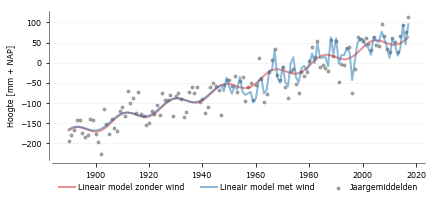

In [8]:
plotting.set_rcparams()


fig, ax = plt.subplots(figsize=(17/2.54, 7/2.54))

plotting.simplify_axes(ax, rescale=False)
ax.scatter(mean_df['year'], mean_df['height'], color='grey', alpha=0.7, s=8, label='Jaargemiddelden')


ax.plot(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    lw=2, 
    label='Lineair model zonder wind', 
    color='C3',
    alpha=0.5
)

ax.plot(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    lw=2, 
    label='Lineair model met wind', 
    color='C0',
    alpha=0.5
)


lg = ax.legend(fontsize=8, fancybox=False, bbox_to_anchor=(0.5, -0.10), loc='upper center', ncol=3, framealpha=0.0)
ax.grid(axis='y') 

ax.set_ylabel('Hoogte [mm + NAP]', fontsize=8)

fig.savefig(r'd:\Documents\2695.50 Zeespiegelstijging 2018\Rapportage\Rapportage 2018\figures\slr_mean_linear.pdf',
           bbox_extra_artists=(lg, ), bbox_inches='tight')



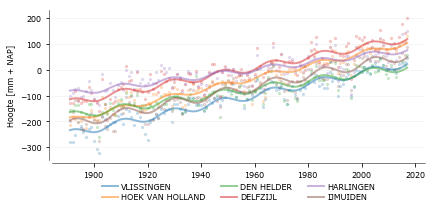

In [9]:
fig, ax = plt.subplots(figsize=(17/2.54, 7/2.54))
plotting.simplify_axes(ax, rescale=False)


for i, row in enumerate(rlr_data.itertuples()):
    station = row.name
    data = row.data[row.data.year > 1890]
    
    station_fit, _ = linear_model(data, with_wind=False, with_season=False)
    

    ax.scatter(data['year'], data['height'], alpha=0.2, s=5, color=f'C{i}', label=None)

    ax.plot(station_fit.model.exog[:, 1] + 1970, station_fit.predict(), lw=2, label=station, alpha=0.5, color=f'C{i}')


lg = ax.legend(fontsize=8, fancybox=False, bbox_to_anchor=(0.5, -0.10), loc='upper center', ncol=3, framealpha=0.0)
ax.grid(axis='y') 

ax.set_ylabel('Hoogte [mm + NAP]', fontsize=8)

fig.savefig(r'd:\Documents\2695.50 Zeespiegelstijging 2018\Rapportage\Rapportage 2018\figures\slr_6stations.pdf',
           bbox_extra_artists=(lg, ), bbox_inches='tight')


    

In [10]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1979)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HAC', cov_kwds={'maxlags':1})
    return fit, names

linear_surge_fit, _ = linear_model_with_surge(mean_df)

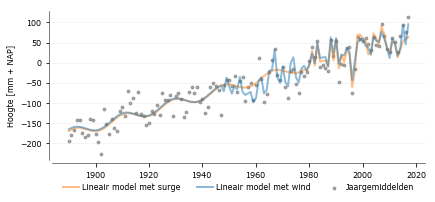

In [11]:
plotting.set_rcparams()


fig, ax = plt.subplots(figsize=(17/2.54, 7/2.54))

plotting.simplify_axes(ax, rescale=False)
ax.scatter(mean_df['year'], mean_df['height'], color='grey', alpha=0.7, s=8, label='Jaargemiddelden')


ax.plot(
    linear_surge_fit.model.exog[:, 1] + 1970, 
    linear_surge_fit.predict(), 
    lw=2, 
    label='Lineair model met surge', 
    color='C1',
    alpha=0.5
)

ax.plot(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    lw=2, 
    label='Lineair model met wind', 
    color='C0',
    alpha=0.5
)


lg = ax.legend(fontsize=8, fancybox=False, bbox_to_anchor=(0.5, -0.10), loc='upper center', ncol=3, framealpha=0.0)
ax.grid(axis='y') 

ax.set_ylabel('Hoogte [mm + NAP]', fontsize=8)

fig.savefig(r'd:\Documents\2695.50 Zeespiegelstijging 2018\Rapportage\Rapportage 2018\figures\slr_mean_surge.pdf',
           bbox_extra_artists=(lg, ), bbox_inches='tight')



In [12]:
# define the statistical model
def broken_linear_model(df):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    
    X = np.c_[
        X,
        df['u2main'],
        df['u2perp']
    ]
        
    X = sm.add_constant(X)
    model_broken_linear = sm.OLS(y, X)
    fit = model_broken_linear.fit(cov_type='HAC', cov_kwds={'maxlags':1})
    return fit
broken_linear_fit = broken_linear_model(mean_df)

In [13]:
# define the statistical model
def quadratic_model(df):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    
    X = np.c_[
        X,
        df['u2main'],
        df['u2perp']
    ]
    
    X = sm.add_constant(X)
    model_quadratic = sm.OLS(y, X)
    fit = model_quadratic.fit(cov_type='HAC', cov_kwds={'maxlags':1})
    return fit
quadratic_fit = quadratic_model(mean_df)

PermissionError: [Errno 13] Permission denied: 'd:\\Documents\\2695.50 Zeespiegelstijging 2018\\Rapportage\\Rapportage 2018\\figures\\slr_3models.pdf'

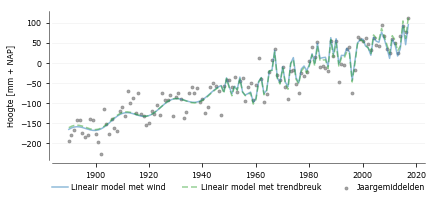

In [14]:
plotting.set_rcparams()


fig, ax = plt.subplots(figsize=(17/2.54, 7/2.54))

plotting.simplify_axes(ax, rescale=False)
ax.scatter(mean_df['year'], mean_df['height'], color='grey', alpha=0.7, s=8, label='Jaargemiddelden')



ax.plot(
    linear_with_corrected_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_corrected_wind_fit.predict(), 
    lw=1.5, 
    label='Lineair model met wind', 
    color='C0',
    alpha=0.5
    
)

ax.plot(
    broken_linear_fit.model.exog[:, 1] + 1970, 
    broken_linear_fit.predict(), 
    lw=1.5, 
    label='Lineair model met trendbreuk', 
    color='C2',
    alpha=0.5,
    dashes=(4, 2)
)


# ax.plot(
#     quadratic_fit.model.exog[:, 1] + 1970, 
#     quadratic_fit.predict(), 
#     lw=2, 
#     label='Kwadratisch model met wind', 
#     color='C6',
#     alpha=0.5
# )


lg = ax.legend(fontsize=8, fancybox=False, bbox_to_anchor=(0.5, -0.10), loc='upper center', ncol=3, framealpha=0.0)
ax.grid(axis='y') 

ax.set_ylabel('Hoogte [mm + NAP]', fontsize=8)

fig.savefig(r'd:\Documents\2695.50 Zeespiegelstijging 2018\Rapportage\Rapportage 2018\figures\slr_3models.pdf',
           bbox_extra_artists=(lg, ), bbox_inches='tight')



In [ ]:
print(linear_with_corrected_wind_fit.aic, broken_linear_fit.aic, quadratic_fit.aic)


In [ ]:
linear_with_corrected_wind_fit.summary(xname=['const', 'trend', 'nodal_u', 'nodal_v', 'wind_main', 'wind_langs'])

In [ ]:
broken_linear_fit.summary(xname=['const', 'trend', 'breuk', 'nodal_u', 'nodal_v', 'wind_main', 'wind_langs'])

In [ ]:
quadratic_fit.summary(xname=['const', 'trend', 'kwad', 'nodal_u', 'nodal_v', 'wind_main', 'wind_langs'])